In [9]:
from prophet import Prophet
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
import prophet
warnings.filterwarnings('ignore')

In [10]:
data=pd.read_csv('univariate_models/multivar.csv', index_col=0, parse_dates=[0])
data= data.set_index('date')
print(data.shape)
data.head()

(2023, 52)


,iso_code,continent,location,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,...,new_deaths_4_week_min,year,season,comparison_with_previous,icu_utilization_ratio,healthcare_strain_index,cumulative_cases_threshold,gdp_stringency_interaction,Holiday,Normal day
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,BEL,Europe,Belgium,1.0,0.0,0.0,0.086,0.000,NaN,NaN,...,NaN,2020,Spring,NaN,NaN,NaN,0,4.739368e+05,0,1
2020-03-08,BEL,Europe,Belgium,316.0,315.0,0.0,27.111,27.025,0.000,0.000,...,NaN,2020,Spring,0.0,0.000000,0.000000,1,5.925276e+05,0,1
2020-03-15,BEL,Europe,Belgium,1362.0,1046.0,9.0,116.850,89.740,4.547,22.564,...,NaN,2020,Spring,9.0,0.080621,4.806915,2,2.172601e+06,0,1
2020-03-22,BEL,Europe,Belgium,4473.0,3111.0,140.0,383.753,266.903,27.969,142.503,...,0.0,2020,Spring,131.0,0.495904,30.225532,3,3.475821e+06,0,1
2020-03-29,BEL,Europe,Belgium,12031.0,7558.0,602.0,1032.179,648.426,82.447,389.158,...,0.0,2020,Spring,462.0,1.461826,83.617908,4,3.475821e+06,0,1


In [11]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 
data=process(data)

data = pd.get_dummies(data)
train_size = int(len(data) * 0.8)
train=data.iloc[:train_size ] 
test=data.iloc[train_size: ] 
print(train.shape, test.shape)
data.head()

(16167, 83) (4042, 83)


,new_deaths,lag1_total_cases,lag1_new_cases,lag1_new_deaths,lag1_total_cases_per_million,lag1_new_cases_per_million,lag1_icu_patients_per_million,lag1_hosp_patients_per_million,lag1_weekly_icu_admissions_per_million,lag1_weekly_hosp_admissions_per_million,...,lag1_location_Malaysia,lag1_location_United States,lag1_tests_units_0,lag1_tests_units_people tested,lag1_tests_units_tests performed,lag1_season_0,lag1_season_Autumn,lag1_season_Spring,lag1_season_Summer,lag1_season_Winter
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.0,...,False,False,True,False,False,True,False,False,False,False
2020-03-01,0.0,4848745.0,0.0,0.0,415989.793,0.0,0.000,0.00,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True
2020-03-01,0.0,5329103.0,0.0,0.0,271841.194,0.0,0.000,0.00,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True
2020-03-01,0.0,0.0,0.0,0.0,0.000,0.0,2.287,22.87,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True
2020-03-01,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.00,0.0,0.0,...,False,False,True,False,False,False,False,False,False,True


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


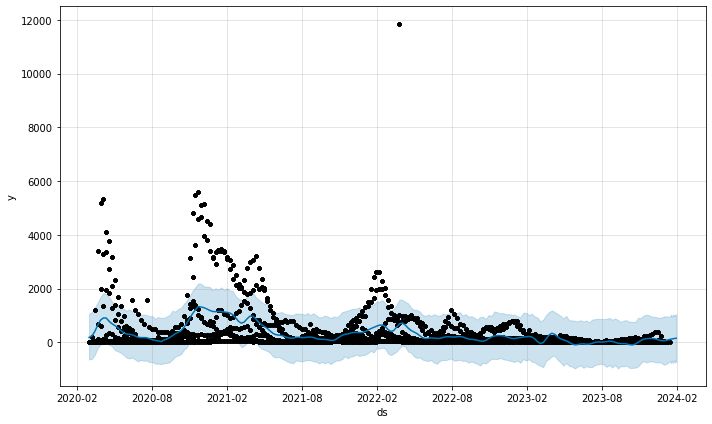

In [12]:
model = Prophet()
model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_deaths':'y'}))
# Create the time range for the forecast
future_baseline = model.make_future_dataframe(periods=16)

# Make prediction
forecast_baseline = model.predict(future_baseline)

# Visualize the forecast
model.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart